# 초기 세팅

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [ ]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [ ]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [ ]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [ ]:
# datasets

trainset = torchvision.datasets.CIFAR10(root ='/content',
                                        train = True, download = True,
                                        transform = CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root ='/content',
                                        train = False, download = True,
                                        transform = CIFAR_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [ ]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)

test_loader = DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)

In [ ]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

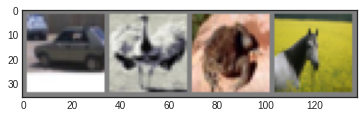

car	 bird	 frog	 horse	


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1), # 64 * 32 * 32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2) # 64 * 16 * 16
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = 3, padding = 1), # 96 * 16 * 16
            nn.BatchNorm2d(96),
            nn.ReLU(inplace = True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 96, out_channels = 64, kernel_size = 5, padding = 1), # 64 * 14 * 14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3), # 32 * 12 * 12
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 5), # 16 * 8 * 8
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True)
        )
        self.layer6 = nn.Sequential(
            nn.Linear(in_features = 16*8*8, out_features = 1000, bias = True),
            nn.ReLU(inplace = True)
        )
        self.layer7 = nn.Sequential(
            nn.Linear(in_features = 1000, out_features = 100, bias = True),
            nn.ReLU(inplace = True)
        )
        self.layer8 = nn.Sequential(
            nn.Linear(in_features = 100, out_features = 10, bias = True),
            nn.ReLU(inplace = True)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.shape[0], -1)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        return x
        

In [ ]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(96, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d(32, 16, 

In [ ]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [ ]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [ ]:
# 모델 구조 확인

summary(myNet, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
              ReLU-3            [4, 64, 32, 32]               0
         MaxPool2d-4            [4, 64, 16, 16]               0
            Conv2d-5            [4, 96, 16, 16]          55,392
       BatchNorm2d-6            [4, 96, 16, 16]             192
              ReLU-7            [4, 96, 16, 16]               0
            Conv2d-8            [4, 64, 14, 14]         153,664
       BatchNorm2d-9            [4, 64, 14, 14]             128
             ReLU-10            [4, 64, 14, 14]               0
           Conv2d-11            [4, 32, 12, 12]          18,464
      BatchNorm2d-12            [4, 32, 12, 12]              64
             ReLU-13            [4, 32, 12, 12]               0
           Conv2d-14              [4, 1

## 손실함수와 옵티마이저

In [ ]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [92]:
# epochs = 10

for epoch in range(20):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # 가중치 초기화

        outputs = myNet(inputs)                            # y_pred
        loss = criterion(outputs, labels)                   # 손실함수를 이용해서 loss계산
        loss.backward()                            # back-propagation
        optimizer.step()                            # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.9944326943159103
Epoch: 1, Batch: 4000, Loss: 1.7196050847619773
Epoch: 1, Batch: 6000, Loss: 1.5760955739691853
Epoch: 1, Batch: 8000, Loss: 1.478139971718192
Epoch: 1, Batch: 10000, Loss: 1.2981698459610342
Epoch: 1, Batch: 12000, Loss: 1.2372364782784133
Epoch: 2, Batch: 2000, Loss: 1.1285096231549978
Epoch: 2, Batch: 4000, Loss: 1.0924526733104138
Epoch: 2, Batch: 6000, Loss: 1.0447517732717098
Epoch: 2, Batch: 8000, Loss: 1.0482769909705967
Epoch: 2, Batch: 10000, Loss: 1.0029534977348522
Epoch: 2, Batch: 12000, Loss: 0.9509350222768262
Epoch: 3, Batch: 2000, Loss: 0.9050228373343125
Epoch: 3, Batch: 4000, Loss: 0.8804229669040069
Epoch: 3, Batch: 6000, Loss: 0.8843655155710876
Epoch: 3, Batch: 8000, Loss: 0.8455998873515055
Epoch: 3, Batch: 10000, Loss: 0.816582222297322
Epoch: 3, Batch: 12000, Loss: 0.8468102275126148
Epoch: 4, Batch: 2000, Loss: 0.7685293841601815
Epoch: 4, Batch: 4000, Loss: 0.7461525280658389
Epoch: 4, Batch: 6000, Loss: 0.74483

## 모델의 저장 및 로드

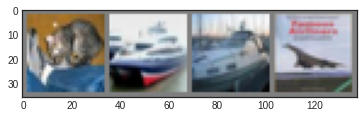

	cat 	ship 	ship 	plane


In [93]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [94]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [95]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [96]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)                                              # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = myNet(images)                                              # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

75.25


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [97]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 77.9%
Accuracy of car: 84.3%
Accuracy of bird: 68.9%
Accuracy of cat: 60.1%
Accuracy of deer: 69.0%
Accuracy of dog: 62.5%
Accuracy of frog: 79.9%
Accuracy of horse: 79.4%
Accuracy of ship: 90.2%
Accuracy of truck: 80.3%


# CIFAR10 분류 모델_v2
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [98]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [99]:
# datasets

trainset = torchvision.datasets.CIFAR10(root ='/content',
                                        train = True, download = True,
                                        transform = CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root ='/content',
                                        train = False, download = True,
                                        transform = CIFAR_transform)

Files already downloaded and verified
Files already downloaded and verified


In [100]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)

test_loader = DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)

In [101]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

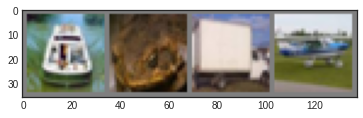

ship	 frog	 truck	 plane	


In [102]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [110]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1), # 64 * 32 * 32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2) # 64 * 16 * 16
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = 3, padding = 1), # 96 * 16 * 16
            nn.BatchNorm2d(96),
            nn.ReLU(inplace = True)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels = 96, out_channels = 64, kernel_size = 5, padding = 1), # 64 * 14 * 14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3), # 32 * 12 * 12
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 5), # 16 * 8 * 8
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True)
        )
        self.layer6 = nn.Sequential(
            nn.Linear(in_features = 16*8*8, out_features = 500, bias = True),
            nn.ReLU(inplace = True)
        )
        self.layer7 = nn.Sequential(
            nn.Linear(in_features = 500, out_features = 100, bias = True),
            nn.ReLU(inplace = True)
        )
        self.layer8 = nn.Sequential(
            nn.Linear(in_features = 100, out_features = 10, bias = True),
            nn.ReLU(inplace = True)
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.shape[0], -1)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)

        return x
        

In [111]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(96, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer5): Sequential(
    (0): Conv2d(32, 16, 

In [112]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [113]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [114]:
# 모델 구조 확인

summary(myNet, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [4, 64, 32, 32]           1,792
       BatchNorm2d-2            [4, 64, 32, 32]             128
              ReLU-3            [4, 64, 32, 32]               0
         MaxPool2d-4            [4, 64, 16, 16]               0
            Conv2d-5            [4, 96, 16, 16]          55,392
       BatchNorm2d-6            [4, 96, 16, 16]             192
              ReLU-7            [4, 96, 16, 16]               0
            Conv2d-8            [4, 64, 14, 14]         153,664
       BatchNorm2d-9            [4, 64, 14, 14]             128
             ReLU-10            [4, 64, 14, 14]               0
           Conv2d-11            [4, 32, 12, 12]          18,464
      BatchNorm2d-12            [4, 32, 12, 12]              64
             ReLU-13            [4, 32, 12, 12]               0
           Conv2d-14              [4, 1

## 손실함수와 옵티마이저

In [115]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr = 0.001, momentum = 0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [117]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # 가중치 초기화

        outputs = myNet(inputs)                            # y_pred
        loss = criterion(outputs, labels)                   # 손실함수를 이용해서 loss계산
        loss.backward()                            # back-propagation
        optimizer.step()                            # 가중치 업데이트

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.9071026119589805
Epoch: 1, Batch: 4000, Loss: 1.59586042791605
Epoch: 1, Batch: 6000, Loss: 1.4347970933392644
Epoch: 1, Batch: 8000, Loss: 1.3550861471891402
Epoch: 1, Batch: 10000, Loss: 1.2597248390577733
Epoch: 1, Batch: 12000, Loss: 1.1863849127851427
Epoch: 2, Batch: 2000, Loss: 1.090093421459198
Epoch: 2, Batch: 4000, Loss: 1.084364891268313
Epoch: 2, Batch: 6000, Loss: 1.0430894188135862
Epoch: 2, Batch: 8000, Loss: 0.99934703951329
Epoch: 2, Batch: 10000, Loss: 0.981604817468673
Epoch: 2, Batch: 12000, Loss: 0.9740484616160393
Epoch: 3, Batch: 2000, Loss: 0.891516865122132
Epoch: 3, Batch: 4000, Loss: 0.8647524702870287
Epoch: 3, Batch: 6000, Loss: 0.874167462696787
Epoch: 3, Batch: 8000, Loss: 0.8391057065674103
Epoch: 3, Batch: 10000, Loss: 0.8424049329720438
Epoch: 3, Batch: 12000, Loss: 0.8302635683701374
Epoch: 4, Batch: 2000, Loss: 0.7567689899352845
Epoch: 4, Batch: 4000, Loss: 0.7585687924281228
Epoch: 4, Batch: 6000, Loss: 0.742620172700

## 모델의 저장 및 로드

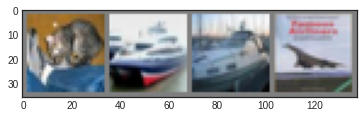

	cat 	ship 	ship 	plane


In [118]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [119]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [120]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [121]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)                                              # model객체도 gpu에 저장했음으로, 사용되는 데이터도 gpu에 저장한다.; to(device) 사용
        outputs = myNet(images)                                              # y_pred
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

76.72


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [122]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 72.0%
Accuracy of car: 90.7%
Accuracy of bird: 68.0%
Accuracy of cat: 62.3%
Accuracy of deer: 76.3%
Accuracy of dog: 65.2%
Accuracy of frog: 85.4%
Accuracy of horse: 80.0%
Accuracy of ship: 84.2%
Accuracy of truck: 83.1%
